In [1]:
# Import packages
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
#import math
import seaborn as sns
%matplotlib inline
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pandas import concat
from matplotlib import pyplot
from pandas.plotting import scatter_matrix

In [2]:
import datetime
from datetime import datetime
from datetime import timedelta

#### Organization
This is attempt to make some organizational structure to the main methods included here:

Some analysis has been made to identify modern approaches to time series pattern recognition (including regime switch) forecasting. The detailed references are skipped but it looks like the major approaches are:
1. Traditional financial econometrics ARIMA, ARCH,GARCH, etc. models
2. Windowed Dynamic time warping (identifies exact copies of patterns)
3. Time series fingerprinting: e.g. (Symbolic Aggregate Approximation (SAX)) — you compute aggregate statistics and see if you can identify instances of it in the data.
4. Hidden Markov Models (HMM)
5. DNN (e.g. RNN , LSTM models)
6. Some general ML classification techniques on engineered features (e.g. Random Forest, XGBoosing, etc.)



Following modeling results were __included__ in this case study:

1. ARIMA model predicting prices - time series model is explained on its own lags (past values)
2. Synthetic features like percentage changes, log returns, moving averages, etc. have been engineered and fed as inputs to selected ML algorithms. Grid Search algorithm was then performed to find best model parameters in hyperparameter space and finally best model was evaluated on an unseen test set.
3. Short conclusions and model limitations mentioned


On a separate note - there are some experimental results for HMM and LSTM and those would be provided in separate notebook.

There are many other techniques like exponential smoothing (weighted moving average method), or  Holt Winter's like algorithms which are interesting but are not included

Some preliminary reading on data origins and methods has been made on materials from [1].

The standard data loading, cleaning and missing values filling steps are below, followed by data exploration.

In [3]:
#used as temporary solution - if there's time must fill missing values in a more meaningful way
df = pd.read_csv('data.csv').fillna(method='ffill')
df.head(15)

# add drop dups
df.drop_duplicates(keep=False,inplace=True) 

,Date,P,D,E,CPI,Fraction,GS10,Price,Dividend,Earnings
0,"1871,01","4,44","0,26","0,40","12,46","1871,04","5,32","91,37","5,35","8,23"
1,"1871,02","4,50","0,26","0,40","12,84","1871,13","5,32","89,86","5,19","7,99"
2,"1871,03","4,61","0,26","0,40","13,03","1871,21","5,33","90,71","5,12","7,87"
3,"1871,04","4,74","0,26","0,40","12,56","1871,29","5,33","96,81","5,31","8,17"
4,"1871,05","4,86","0,26","0,40","12,27","1871,37","5,33","101,57","5,43","8,36"
5,"1871,06","4,82","0,26","0,40","12,08","1871,46","5,34","102,32","5,52","8,49"
6,"1871,07","4,73","0,26","0,40","12,08","1871,54","5,34","100,41","5,52","8,49"
7,"1871,08","4,79","0,26","0,40","11,89","1871,62","5,34","103,31","5,61","8,63"
8,"1871,09","4,84","0,26","0,40","12,18","1871,71","5,35","101,94","5,48","8,42"
9,"1871,1","4,59","0,26","0,40","12,37","1871,79","5,35","95,19","5,39","8,30"


In [4]:
def parse_date2(date):
    if date.endswith(",1"):
        date += "0"
    return datetime.strptime(date, "%Y,%m")

In [5]:
"""def parse_date(date):
    year, month = date.split(",", maxsplit=1)
    if month == "1":
        month = "10"
    return datetime(int(year), int(month), 1)"""

'def parse_date(date):\n    year, month = date.split(",", maxsplit=1)\n    if month == "1":\n        month = "10"\n    return datetime(int(year), int(month), 1)'

In [6]:
# dared to drop Fractions column as the initial research shown it is not adding much value
# e.g. https://datahub.io/core/s-and-p-500
df.drop("Fraction", axis=1, inplace=True)

In [7]:
df['Date'] = df['Date'].apply(parse_date2)

In [8]:
df.head(25)

,Date,P,D,E,CPI,GS10,Price,Dividend,Earnings
0,1871-01-01,"4,44","0,26","0,40","12,46","5,32","91,37","5,35","8,23"
1,1871-02-01,"4,50","0,26","0,40","12,84","5,32","89,86","5,19","7,99"
2,1871-03-01,"4,61","0,26","0,40","13,03","5,33","90,71","5,12","7,87"
3,1871-04-01,"4,74","0,26","0,40","12,56","5,33","96,81","5,31","8,17"
4,1871-05-01,"4,86","0,26","0,40","12,27","5,33","101,57","5,43","8,36"
5,1871-06-01,"4,82","0,26","0,40","12,08","5,34","102,32","5,52","8,49"
6,1871-07-01,"4,73","0,26","0,40","12,08","5,34","100,41","5,52","8,49"
7,1871-08-01,"4,79","0,26","0,40","11,89","5,34","103,31","5,61","8,63"
8,1871-09-01,"4,84","0,26","0,40","12,18","5,35","101,94","5,48","8,42"
9,1871-10-01,"4,59","0,26","0,40","12,37","5,35","95,19","5,39","8,30"


In [9]:
df = df.set_index('Date')

In [10]:
# those are dtype (str) type of objects and need to be converted
df['P'].apply(type).value_counts()

<class 'str'>    1783
Name: P, dtype: int64

In [11]:
# defining auxiliary cleaning function
def clean_column(x):
    """ the values are str objects containing ',' those have been replaced with '.'
    """
    if isinstance(x, str):
        return(x.replace(',', '.'))
    return(x)

In [12]:
#df['P'] = df['P'].apply(clean_column).astype('float')
cols = df.columns[df.dtypes.eq('object')]
cols

Index(['P', 'D', 'E', 'CPI', 'GS10', 'Price', 'Dividend', 'Earnings'], dtype='object')

In [13]:
#selecting all 'object' type of columns in one shot
# there might be even shorter way - skipping for loop - investigate later if time permits
cols = df.columns[df.dtypes.eq('object')]

for column in cols:
    df[column] = df[column].apply(clean_column).astype('float')

In [14]:
df.head(10)

,P,D,E,CPI,GS10,Price,Dividend,Earnings
Date,,,,,,,,
1871-01-01,4.44,0.26,0.4,12.46,5.32,91.37,5.35,8.23
1871-02-01,4.50,0.26,0.4,12.84,5.32,89.86,5.19,7.99
1871-03-01,4.61,0.26,0.4,13.03,5.33,90.71,5.12,7.87
1871-04-01,4.74,0.26,0.4,12.56,5.33,96.81,5.31,8.17
1871-05-01,4.86,0.26,0.4,12.27,5.33,101.57,5.43,8.36
1871-06-01,4.82,0.26,0.4,12.08,5.34,102.32,5.52,8.49
1871-07-01,4.73,0.26,0.4,12.08,5.34,100.41,5.52,8.49
1871-08-01,4.79,0.26,0.4,11.89,5.34,103.31,5.61,8.63
1871-09-01,4.84,0.26,0.4,12.18,5.35,101.94,5.48,8.42


In [15]:
#df['Price'].hist()

In [16]:
# save to file to have a copy
df.to_csv('fotmatted_series.csv')

### Doing Exploratory Data Analysis 

Text(0.5, 0, 'Date')

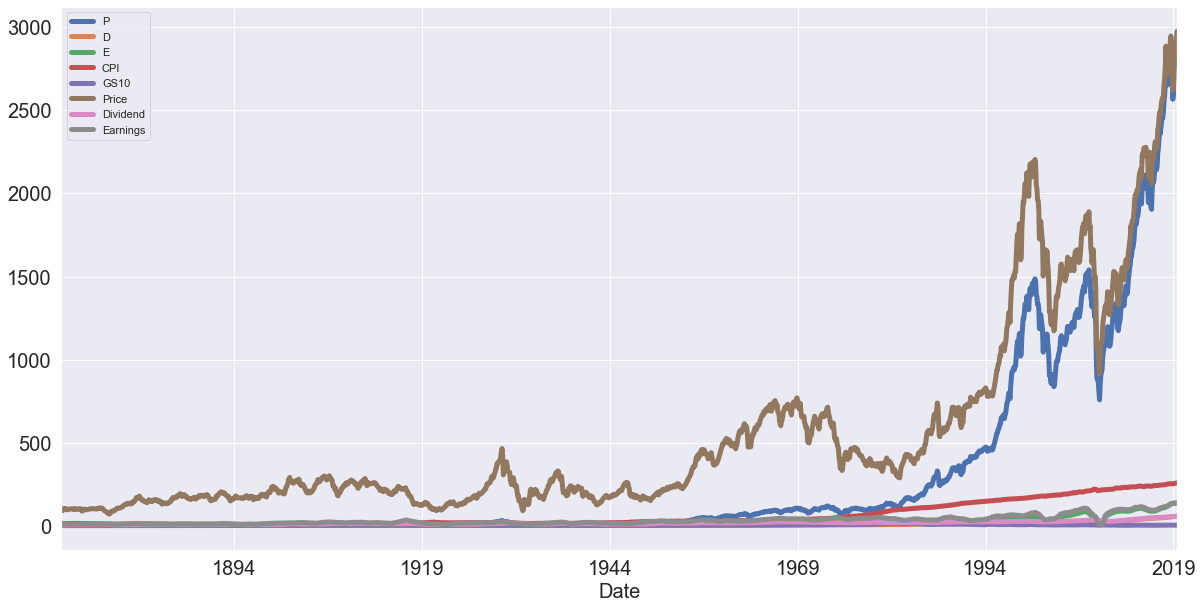

In [17]:
df.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20)

Concentrating on prices grapahs - those do not show any clear trend in the medium long term, although the data seems to be very non-stationary from first glance (statistical properies are not constant throughtout all periods).

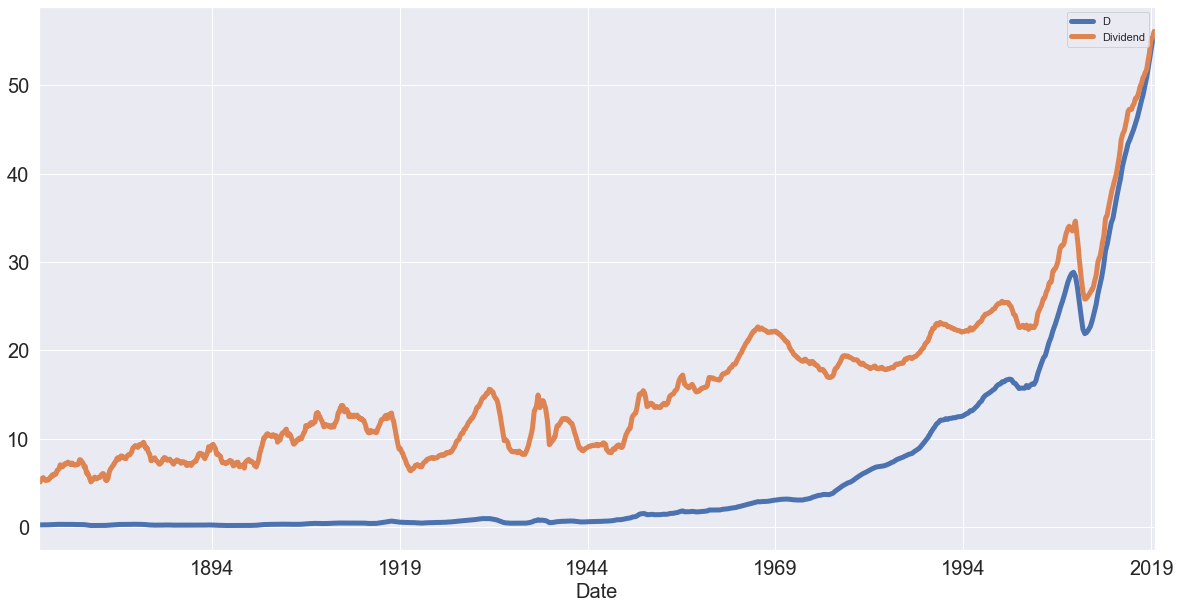

In [18]:
df[['D','Dividend']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20);

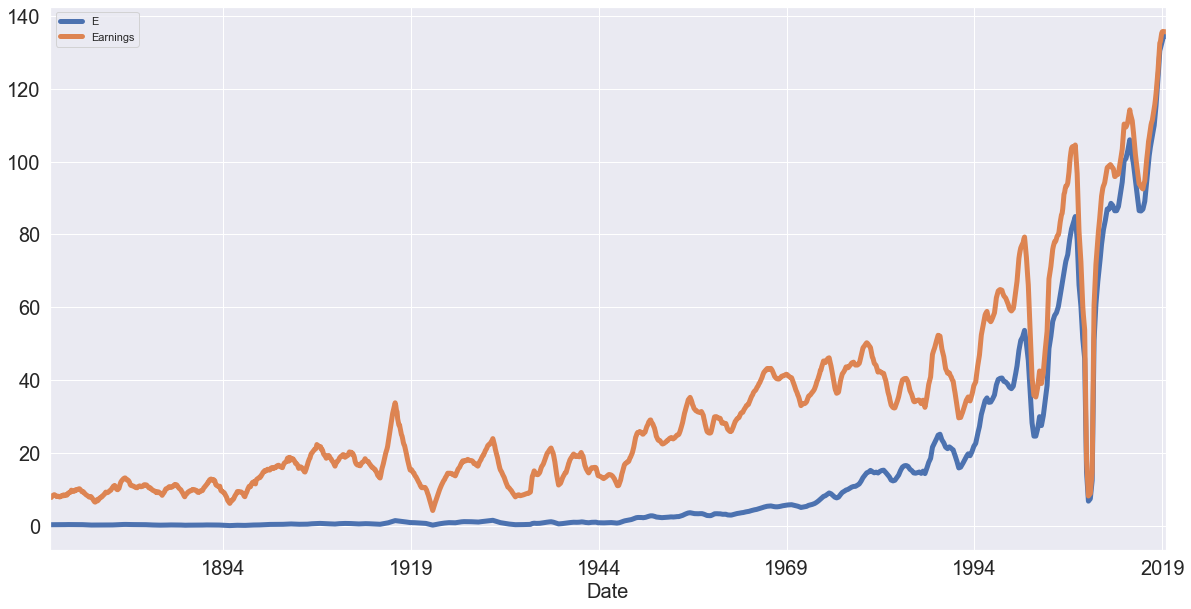

In [19]:
df[['E','Earnings']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20);

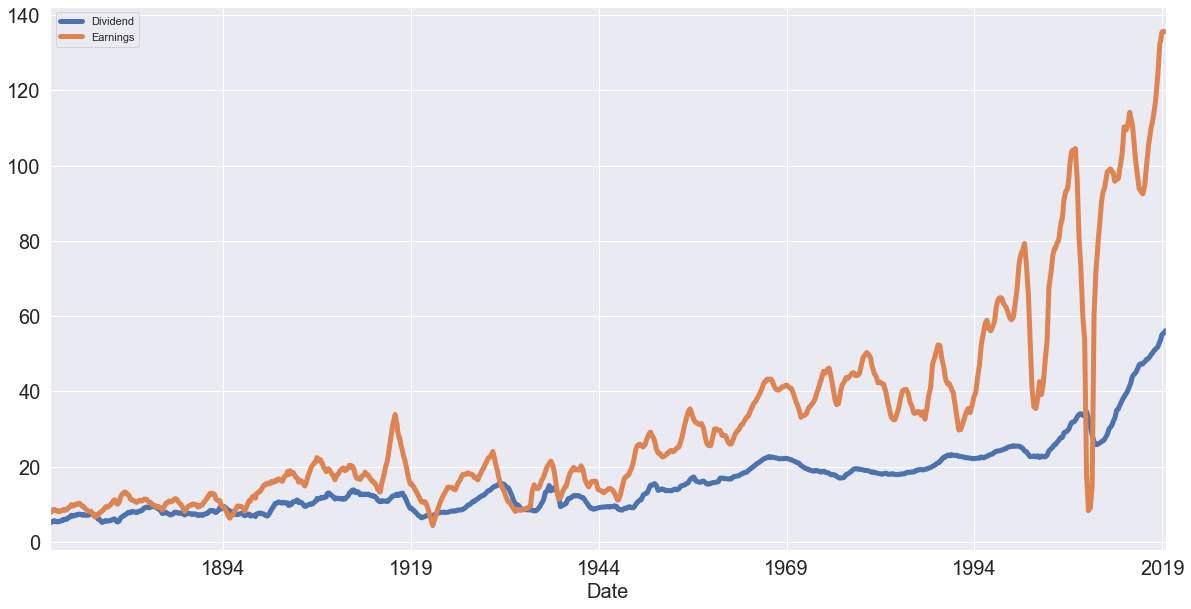

In [20]:
df[['Dividend','Earnings']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20);

Regarding this plot above - for sliced time periods it would be great to investigate a result as suggested by a signalling model on dividend increase positively impacting stock price reactions ( Miller, Rock [4]) .

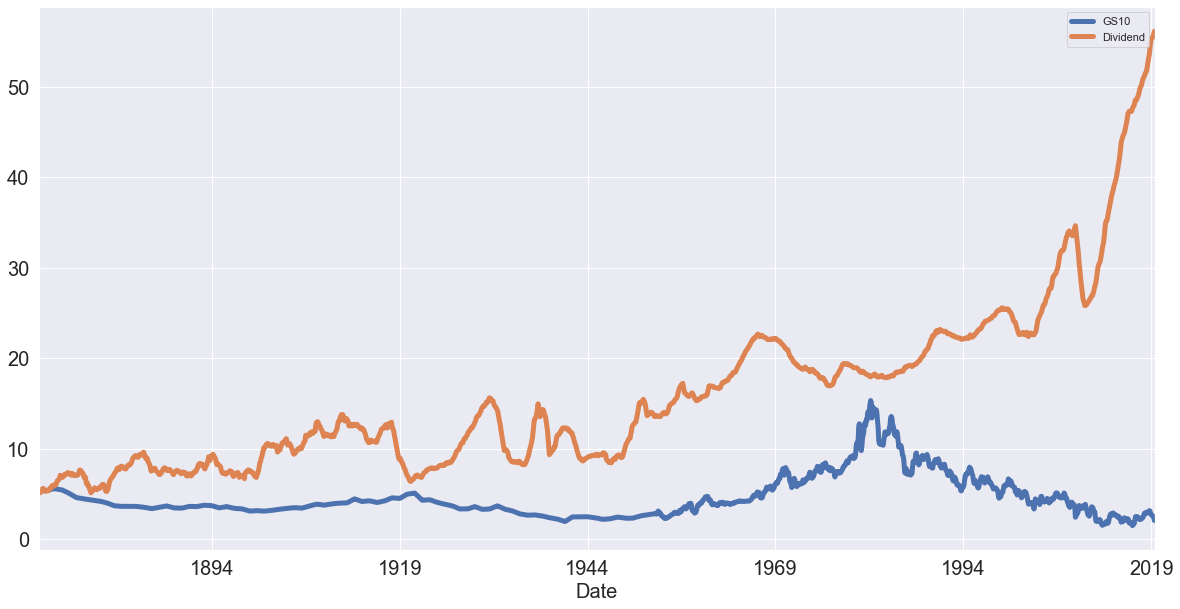

In [21]:
df[['GS10','Dividend']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20);

The preliminary analysis reveals that as the name suggested, the columns in following pairs
are highly positevely correlated with each other: (Price and Aggredate Price), 
(Dividend and Aggredate Dividend) and (Earnings vs Aggredate Earnings). 
To take it further, let's construct the correlation matrix.
GS10 and dividends are somewhat diverging, especially after second half of 80's. This suggests that those are not correlated, something which could be better seen from correlation matrix visualization below:

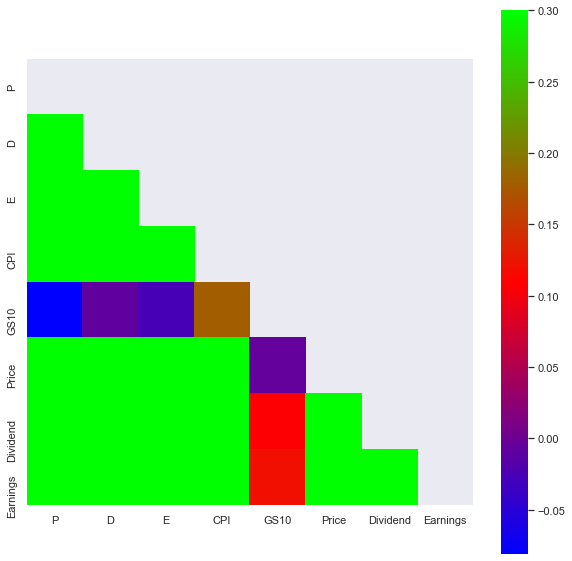

In [22]:
ax, figure = plt.subplots(figsize=(10,10))
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap='brg')
plt.show()

We could see from the correlation map above that many of features do not have high correlations while others are highly inter-correrlated.
Hence,  maybe we can eliminate a  some of those.
One of the approaches is to use the important feature detector of the gradient boosting to determine 
the most important features to be retained. 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000206F7C1D6C8>]],
      dtype=object)

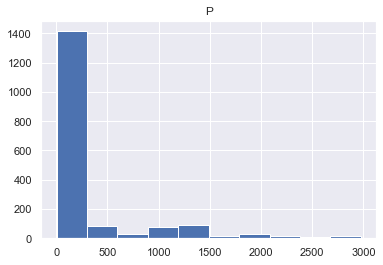

In [23]:
df[['P']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000206F7C1DE48>]],
      dtype=object)

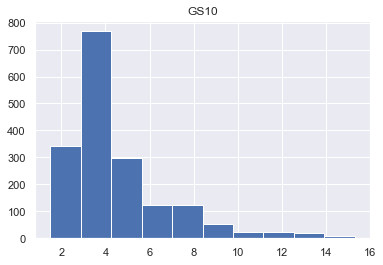

In [24]:
df[['GS10']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000206F887F6C8>]],
      dtype=object)

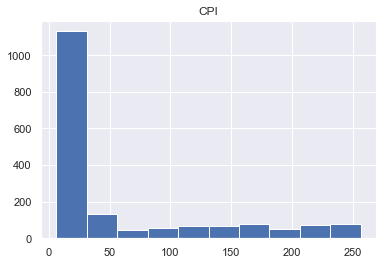

In [25]:
df[['CPI']].hist()

we can see that the data on Price , GS10 are far from being normal and the data 
on CPI is highly skewed. We did not consider Real price, Earnings, Dividends, along with their aggregate counterparts (as those were highly inter-correlated  and results are going to be the same with hight level of confidence).

Let's perform Dickey-Fuller's statistical test to check for data's non-stationarity null hypothesis. The null hypothesis is that the data are non-stationary. We want to REJECT the null hypothesis for this test, so we want a p-value of less that 0.05 (or smaller).
https://nwfsc-timeseries.github.io/atsa-labs/sec-boxjenkins-aug-dickey-fuller.html

In [26]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['GS10'])

print('ADF test statistic: %.02f' % adf_test[0])
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf_test[1])

ADF test statistic: -1.46
	1%: -3.434
	5%: -2.863
	10%: -2.568
p-value: 0.555


In [27]:
# we can accept the null hypothesis about data being non-stationary
# although the distribution is somewhat reminiscent to skewed normal distribution

In [28]:
#now to CPI
adf_test = adfuller(df['CPI'])

print('ADF test statistic: %.02f' % adf_test[0])
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf_test[1])

ADF test statistic: 2.91
	1%: -3.434
	5%: -2.863
	10%: -2.568
p-value: 1.000


In [29]:
#now to aggregate price
adf_test = adfuller(df['P'])

print('ADF test statistic: %.02f' % adf_test[0])
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf_test[1])

ADF test statistic: 4.24
	1%: -3.434
	5%: -2.863
	10%: -2.568
p-value: 1.000


p-value is definitely larger than 0.05 and so we can't reject the null hypothesis about data being non-stationary (having non-constant variance across different time periods, or, in orther words, there are significant volatility clusters observable w.r.t. , say, price). So we admit - data in question is non-stationary based on tests above.

We should somehow think on how to perform transformation to stationary data. That would allow us to work with known models like ARIMA. One of the known techniques is log-transformation.

Remark: in future it would be great to do research on how to find volatility clusterings,
define a distance measure, and relate series as belonging to a certain class based on that measure. When making predicitons we can then relate similar clusters with stationary data (or made it stationary by log transforming) for better prediction results (i.e. avoid making predictions of periods of  market downturn based on series that are performing in a usual way).


In [30]:
from pandas.plotting import lag_plot
series_P = df['P']
series_P.head()


Date
1871-01-01    4.44
1871-02-01    4.50
1871-03-01    4.61
1871-04-01    4.74
1871-05-01    4.86
Name: P, dtype: float64

It's important to know if its correlated (remember there’s an assumption of dependance / correlation for autoregression). To do that we construct a lagplot

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


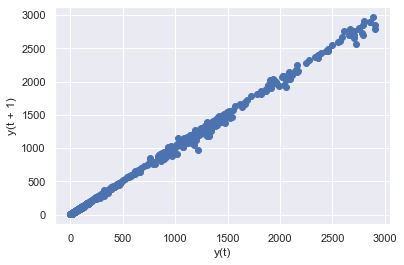

In [31]:
lag_plot(series_P)
pyplot.show()

In [32]:
#The plot created from running the example shows a relatively strong positive correlation 
#between observations and their lag1 values.
#We can repeat this process for an observation and any lag values. Perhaps with the observation 
#at the same time last week, last month, or last year, or any other domain-specific knowledge 
#we may wish to explore.
# we can later do a  forecast on it using autoregression

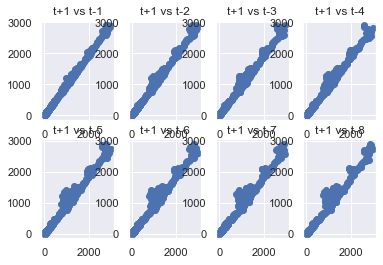

In [33]:
from pandas.plotting import scatter_matrix
from pandas import DataFrame
# find where the error is DataFrame is not recognized now...
values = DataFrame(series_P.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
pyplot.figure(1)
for i in range(1,(lags + 1)):
    ax = pyplot.subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
pyplot.show()

Running the example suggests the strongest relationship between an observation with its lag1 value,
but generally a good positive correlation with each value in the last period.

### Why log returns and moving averages are used: 
we should normalize tha data and draw autocorrelation log returns and lagged log returns and lagged volatilities while looking up for patterns.
Log returns are considered a standard transforamtional practice.
Rest of features are creating new smoothed features. We'd plot some of them, draw inferences from correlation matrix and use them in our ML algorithms below (e.g. moving average can be used as a source of new information when modeling a time series forecast as a supervised learning problem).

In [34]:

df['pct_change'] = df['P'].pct_change().fillna(method='bfill')
df['log_ret_1_mth'] = np.log(df['P'] / df['P'].shift(1)).fillna(method='bfill')

df['Log_Ret_2_mth']=pd.Series(df['log_ret_1_mth']).rolling(window=2).sum()
df['Log_Ret_3_mth']=pd.Series(df['log_ret_1_mth']).rolling(window=3).sum()
df['Log_Ret_4_mth']=pd.Series(df['log_ret_1_mth']).rolling(window=4).sum()
df['Log_Ret_8_mth']=pd.Series(df['log_ret_1_mth']).rolling(window=8).sum()
df['Log_Ret_12_mth']=pd.Series(df['log_ret_1_mth']).rolling(window=12).sum()
df['Log_Ret_48_mth']=pd.Series(df['log_ret_1_mth']).rolling(window=48).sum()


In [35]:
df['volat_2_mth']=pd.Series(df['log_ret_1_mth']).rolling(window=2).std()*np.sqrt(2)
df['volat_3_mth']=pd.Series(df['log_ret_1_mth']).rolling(window=3).std()*np.sqrt(3)
df['volat_4_mth']=pd.Series(df['log_ret_1_mth']).rolling(window=4).std()*np.sqrt(4)
df['volat_8_mth']=pd.Series(df['log_ret_1_mth']).rolling(window=8).std()*np.sqrt(8)
df['volat_12_mth']=pd.Series(df['log_ret_1_mth']).rolling(window=12).std()*np.sqrt(12)
df['volat_48_mth']=pd.Series(df['log_ret_1_mth']).rolling(window=48).std()*np.sqrt(48)


### CAPE ratio engineering
Also, this dataset was created as a part of larger study by Robert J. Shiller, [2]  who invented a precitvive index called CAPE (Cyclically adjusted price-to-earnings ratio)  which is said have a good predictive characteristics. 
Let's try to engineer it from the data we have

We'll also construct 12 months and 10 year moving average features along the way. Those can be used as a source of new information when modeling a time series forecast as a supervised learning problem.


In [36]:
# to catch for so-called trends (moving averages) let's engineer rolling mean 
df['rolling_Earnings_mean12'] = df['Earnings'].rolling(window=12).mean()
df['rolling_Earnings_mean120'] = df['Earnings'].rolling(window=120).mean()
df['CAPE10'] = (df['Price']/df['rolling_Earnings_mean120'])

In [37]:
#df['2008']

General testing of results in 4-5 random years (1882, 1929, 2008-2009) revealed that the calculation is quite matching the original calculations in [2]. They seemed to base calculations on yearly data though, while we have monthly data. I decided to consider results acceptable to some degree, and not to invest time in finding the exact conversion techniques

A q-day moving average is, for a series x_t and a point in time t, the average of the past q days.
Moving averages smooth a series and help identify trends. The larger q is, the less responsive a moving average process is to short-term fluctuations in the series x_t. The idea is that moving average processes help identify trends from "noise". Fast moving averages have smaller q and more closely follow the stock, while slow moving averages have larger q, resulting in them responding less to the fluctuations of the stock and being more stable.

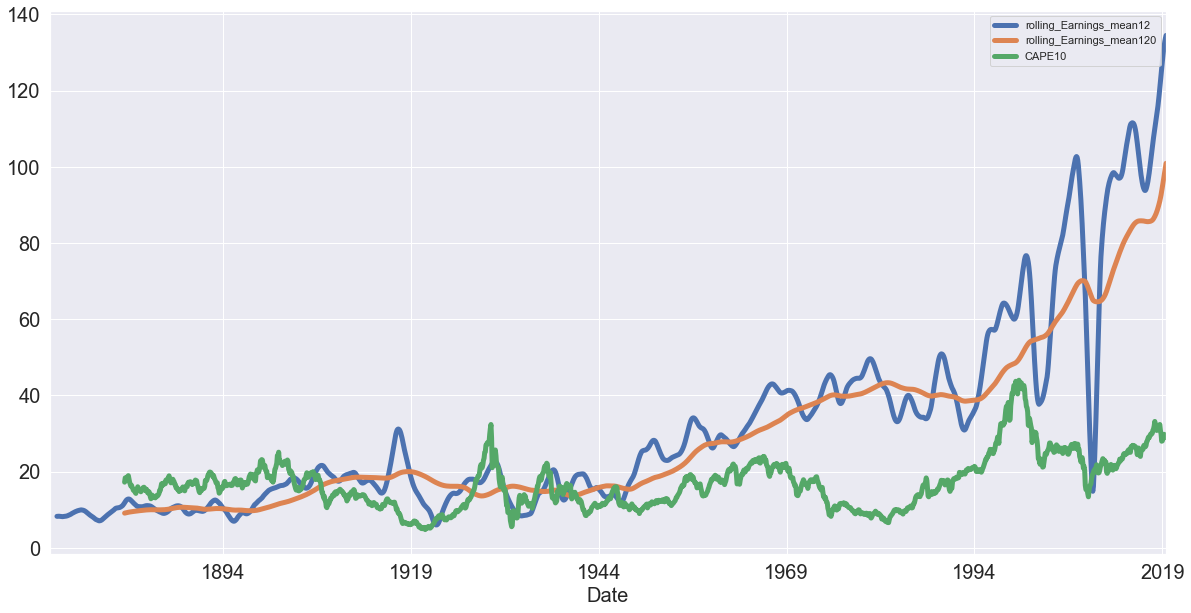

In [38]:
df[['rolling_Earnings_mean12', 'rolling_Earnings_mean120','CAPE10']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20);

Hope to see if CAPE10 has strong enough predictive power.
Notice how late the rolling average for earnings on twelve months (orange line) and 10 years (green line) begins. 
Moving average is much smoother than the actual stock data. Additionally, it’s an indicator for market trend; if the stock is above or below the moving average line for further market direction change. Generally speaking substantial crossing a moving average signals a possible change in trend, and should draw attention. We can observe it above for the dot com crisis (2000-2005) and US mortgage and credit crisis 2007-08. One can see that crossing the moving average lines (especially green one) indicates changes in trend.
In more sophisticated HFT algorithms on can take advantage of a similar pattern and generate buy or sell signals. 
Also, using the rolling means somehow improved stationarity in the series.

In [39]:
# maybe it's possible to construct Bollinger Bands - see https://www.investopedia.com/terms/b/bollingerbands.asp
#here
# as well as https://stackoverflow.com/questions/40742364/pandas-rolling-standard-deviation

Let's has a closer look at the period 2007-01-01 to 2010-01-01 which encompasses the US credit crisis

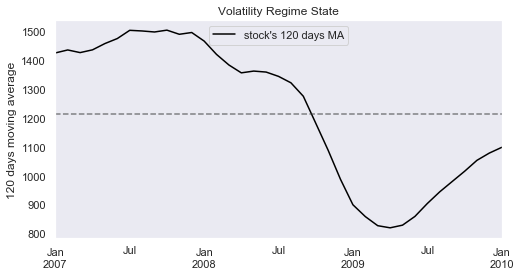

In [40]:
import matplotlib.transforms as mtransforms
# slicing the dataframe
df1 = df.loc['2007-1-1':'2010-1-1']
#
ma=df1['P'].rolling('120d').mean()

state = pd.cut(ma, bins=[-np.inf, 14, 18, 24, np.inf],
               labels=range(4))

cmap = plt.get_cmap('RdYlGn_r')
ma.plot(color='black', linewidth=1.5, marker='', figsize=(8, 4),label='stock\'s 120 days MA')
ax = plt.gca()  # Get the current Axes that ma.plot() references
ax.set_xlabel('')
ax.set_ylabel('120 days moving average')
ax.set_title('Volatility Regime State')
ax.grid(False)
ax.legend(loc='upper center')
ax.set_xlim(xmin=ma.index[0], xmax=ma.index[-1])

ax.axhline(df1['P'].mean(), linestyle='dashed', color='xkcd:dark grey',alpha=0.6, label='Full-period mean', marker='')
# this example was adopted from https://realpython.com/python-matplotlib-guide/


Dashed line above is the full period average. The impact of price decline due to 2007-08 crisis on the 120 days moving average has only become apparent later around January 2009 as we can see from graph

Let's plot Price vs log returns (rolling over 12 months) vs volatility (rolling, annualized)

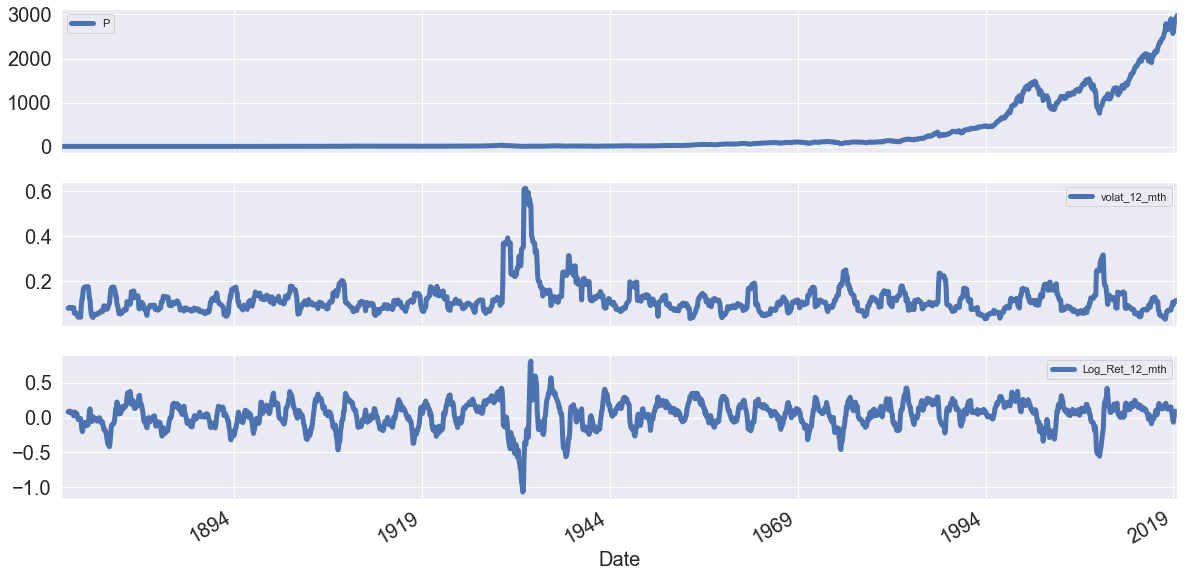

In [41]:
#plotting - Prive vs volat_12_mth  vs log_ret_1_mth
df[['P','volat_12_mth', 'Log_Ret_12_mth']].plot(subplots=True, style='b',figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20);

Log transformation of returns made the series looking better (while retaining the information)

The plots on stock price and moving annualized volatility above are inline with 
 the known statement about the historical moving volatility tending to
 decrease when the markets are on rise and tending to increase
 when markets go down. We just need to slice and dice the df 
 to see it better for known periods (e.g. recent 2008 crisis) if time permits
 furthermore: The evidence for volatility clustering is
shown by the positive serial correlation (correlation of a return series
with itself lagged) in the absolute value of returns which eventually
decays over a period of observations. Volatility clustering can enhance the ability to forecast volatility. This clustering can be shown by plotting a scatter chart of current month versus next
month’s volatility [5]

We will create a direction of change feature. This will be used as out Y variable in coming classification algorithms

In [42]:
# Label data: Up (Down) if the the 1 month logarithmic return increased (decreased)
# shift index axis by a period in negative direction 
 
df['dir']=np.where(df['log_ret_1_mth'] > 0, 1, 0)

In [43]:
# list rows and columns
print("Rows, Columns:")
print(df.shape)

# list columns
print("Columns:")
print(df.columns)

Rows, Columns:
(1783, 26)
Columns:
Index(['P', 'D', 'E', 'CPI', 'GS10', 'Price', 'Dividend', 'Earnings',
       'pct_change', 'log_ret_1_mth', 'Log_Ret_2_mth', 'Log_Ret_3_mth',
       'Log_Ret_4_mth', 'Log_Ret_8_mth', 'Log_Ret_12_mth', 'Log_Ret_48_mth',
       'volat_2_mth', 'volat_3_mth', 'volat_4_mth', 'volat_8_mth',
       'volat_12_mth', 'volat_48_mth', 'rolling_Earnings_mean12',
       'rolling_Earnings_mean120', 'CAPE10', 'dir'],
      dtype='object')


In [44]:
# backfilling with same values, CAPE, volatilities, rolling earning means 
# should not impact much since those are NaN's primarily in 1870's
df.iloc[:].fillna(method='bfill')

,P,D,E,CPI,GS10,Price,Dividend,Earnings,pct_change,log_ret_1_mth,...,volat_2_mth,volat_3_mth,volat_4_mth,volat_8_mth,volat_12_mth,volat_48_mth,rolling_Earnings_mean12,rolling_Earnings_mean120,CAPE10,dir
Date,,,,,,,,,,,,,,,,,,,,,
1871-01-01,4.44,0.26,0.40,12.460,5.32,91.37,5.35,8.23,0.013514,0.013423,...,0.000000,0.010727,0.014804,0.046937,0.080224,0.203138,8.280000,9.124500,17.254644,1
1871-02-01,4.50,0.26,0.40,12.840,5.32,89.86,5.19,7.99,0.013514,0.013423,...,0.000000,0.010727,0.014804,0.046937,0.080224,0.203138,8.280000,9.124500,17.254644,1
1871-03-01,4.61,0.26,0.40,13.030,5.33,90.71,5.12,7.87,0.024444,0.024150,...,0.010727,0.010727,0.014804,0.046937,0.080224,0.203138,8.280000,9.124500,17.254644,1
1871-04-01,4.74,0.26,0.40,12.560,5.33,96.81,5.31,8.17,0.028200,0.027809,...,0.003659,0.012950,0.014804,0.046937,0.080224,0.203138,8.280000,9.124500,17.254644,1
1871-05-01,4.86,0.26,0.40,12.270,5.33,101.57,5.43,8.36,0.025316,0.025001,...,0.002808,0.003316,0.012624,0.046937,0.080224,0.203138,8.280000,9.124500,17.254644,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-01,2803.98,54.94,134.39,254.202,2.57,2829.33,55.44,135.60,0.017830,0.017673,...,0.037344,0.038481,0.095513,0.106777,0.110029,0.183932,130.548333,96.723250,29.251809,1
2019-04-01,2903.80,55.32,134.39,255.548,2.53,2914.62,55.53,135.60,0.035599,0.034980,...,0.017307,0.032369,0.036708,0.110343,0.111620,0.186167,131.799167,97.782333,29.807225,1
2019-05-01,2854.71,55.70,134.39,256.092,2.40,2859.26,55.79,135.60,-0.016905,-0.017050,...,0.052030,0.045893,0.061107,0.110651,0.113528,0.187680,132.892500,98.839417,28.928337,0


Let's plot some correlation matrix to relate features to each other

Text(0.5, 0.98, 'Volatility vs. Rest')

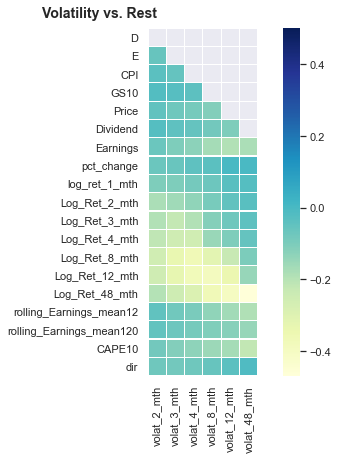

In [45]:
# Plot correlation matrix

vol_cols=df.iloc[:,16:22].columns 

corr=df.iloc[:,1:26].corr().filter(vol_cols).drop(vol_cols)

mask=np.zeros_like(corr); mask[np.triu_indices_from(mask)]=True # we use mask to plot only part of the matrix

heat_fig, (ax)=plt.subplots(1, 1, figsize=(9,6))

heat=sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="YlGnBu")

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Volatility vs. Rest', fontsize=14, fontweight='bold')

#plt.savefig('heat1.eps', dpi=200, format='eps');

There is some kind of fading or dependency between log return for a given period and its lagged volatility (e.g. log return for past 12 months is positively correlated with rolling volatility for 3 past months and even more correlated with that of 4 and 8 months and starting to decay thereafter). Also, some correlation between monthly earnings and volatility in past (e.g. 12, 48 months) is observed.
Let's now plot the histogram of 1 month log returns (ran over price).

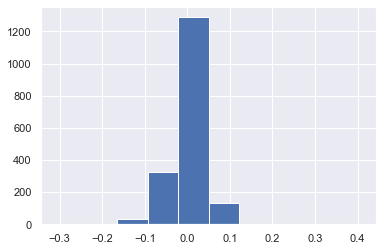

In [46]:
df['log_ret_1_mth'].hist()

In [47]:
# can't really call it normal, but it's better than price on its own

In [48]:
#from pandas.plotting import autocorrelation_plot

#autocorrelation_plot(df['log_ret_1_mth'])
#pyplot.show()

In [49]:
#refers to plot above might be dropped soon
"""The resulting plot shows lag along the x-axis and the correlation 
on the y-axis. Dotted lines are provided that indicate any correlation values 
above those lines are statistically significant (meaningful).We can see that 
for the Aggregate Prices log returns('log_ret' column) we see cycles of strong negative 
and positive correlation. The higher the lag value the lesser the autocorrelation. This captures the relationship of an observation
 with past observations in the same and opposite seasons or times of year.
Sine waves like those seen in this example are a strong sign of seasonality 
in the dataset's Price column."""

"The resulting plot shows lag along the x-axis and the correlation \non the y-axis. Dotted lines are provided that indicate any correlation values \nabove those lines are statistically significant (meaningful).We can see that \nfor the Aggregate Prices log returns('log_ret' column) we see cycles of strong negative \nand positive correlation. The higher the lag value the lesser the autocorrelation. This captures the relationship of an observation\n with past observations in the same and opposite seasons or times of year.\nSine waves like those seen in this example are a strong sign of seasonality \nin the dataset's Price column."

We'll plot autocorrelation (ACF) plot below which represents the autocorrelation of the series with lags of itself.
A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags

The first step of fitting an ARIMA model is to determine the differencing order to stationarize the series (need differencing only if the series is non-stationary, like in our case)

In [50]:
#df.head()

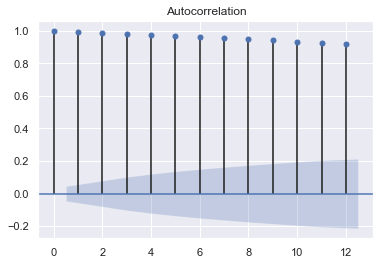

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
x = plot_acf(df['P'], lags=12)

The autocorrelation function shows very high correlation only with previous lag values (prices  predeeding the current price in sequence). It is slowly decreasing sequence though. 

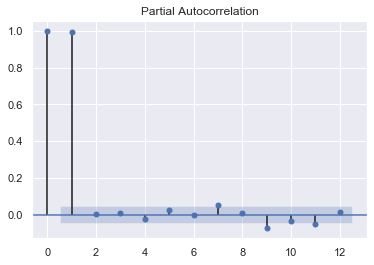

In [52]:
x = plot_pacf(df['P'], lags=12)

The partial autocorrelation function shows a high correlation with the first lag and substantially smaller (negative) correlation with further lags. If we had Here the signature is 2 spikes in PACF, for example that would have been a sign for selection AR(2) model.
But in this case seems that 'p' would be fixed as 1

There's an example of on page 11 of [11a] that is almost identical to this case. There a differencing of order at least 1 is proposed. To quote: _The series is obviously nonstationary—it has a strong upward trend—but there does not appear to be a need for a nonlinear data transformation. A strongly trended series will always have very large positive autocorrelations at all low-order lags and a single spike at lag 1 in the PACF. This is the signature of a series that probably needs to be differenced at least once in order to be made stationary._ This is the assumption for 'd' - (differencing order) parameter that we will make (the description of 'p', 'd', 'q' are listed in ARIMA model section below).

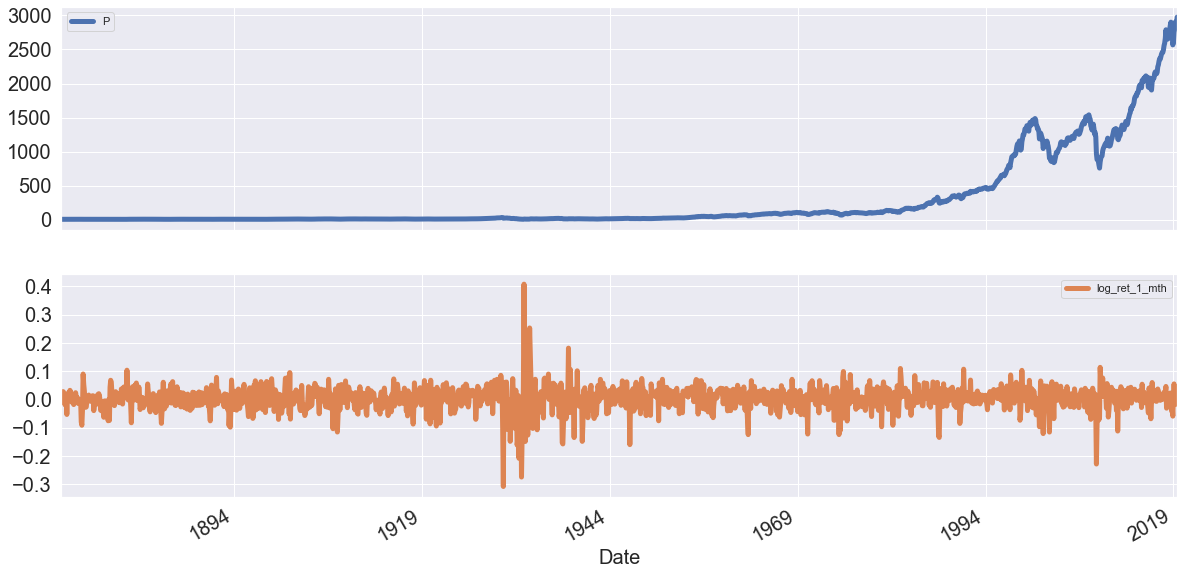

In [53]:
#let's plot log returns
df[['P','log_ret_1_mth']].plot(subplots=True, figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20);

#df[['P','log_ret']].plot(subplots=True, style=‘b’,figsize=(8, 5))

### Choosing a baseline model

ARIMA  is chosen as a baseline model. With ARIMA we remove the trend of the data (via logging), and then look at the differenced series.


ARIMA is used to specifically model non-stationary time series data, for which order of integration is known (p) - we'll infer that from ACF/PACF plots



#### ARIMA params selection
ARIMA models (which include ARMA, AR and MA models) are a general class of models to forecast stationary time series. ARIMA models are made of three parts:

A weighted sum of lagged values of the series (Auto-regressive (AR) part) denoted as 'p' which represents the order of the AR part

A weighted sum of lagged forecasted errors of the series (Moving-average (MA) part) denoted as q - the number of MA terms required to remove any autocorrelation in the stationarized series

A difference of the time series (Integrated (I) part) - denoted as 'd' - the order of differencing

ARIMA(p, d, q)



The first step of fitting an ARIMA model is to determine the differencing order to stationarize the series. To do that, we look at the ACF and PACF plots. Note:

— Rule 1 : If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing. 

— Rule 2 : If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.”

a good comprehensive study by R. Nau, Statistical Forecasting [11] on right set of techniques for autoregressive modelscould be found in references.

Based on preliminary discussion of ACF and PACF plots above we need only d=1 order of differencing and AR(1) (i.e. with p=1) should be chosen as a first selection

In [54]:
#it's usually a good practice to keep a copy of original df to play on safe side
copy_df = df.copy()

y = copy_df['P']
X=copy_df.iloc[:,1:10]
y.head()
# do not really need X_train part - just needed a quick split and copied this line from other part
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.29,shuffle=False)

y_test.head()


Date
1976-06-01    101.8
1976-07-01    104.2
1976-08-01    103.3
1976-09-01    105.5
1976-10-01    101.9
Name: P, dtype: float64

In [55]:
y_test

Date
1976-06-01     101.80
1976-07-01     104.20
1976-08-01     103.30
1976-09-01     105.50
1976-10-01     101.90
               ...   
2019-03-01    2803.98
2019-04-01    2903.80
2019-05-01    2854.71
2019-06-01    2890.17
2019-07-01    2975.95
Name: P, Length: 518, dtype: float64

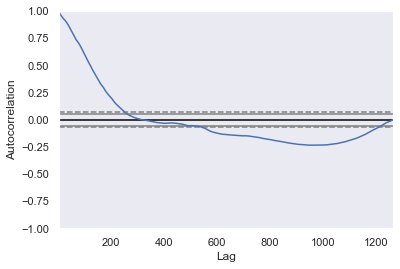

In [56]:
from pandas.plotting import autocorrelation_plot


autocorrelation_plot(y_train).plot(figsize=(200,100), linewidth=5, fontsize=20)
# Plot
plt.show()



Combining with log autocorrelation results with some degree of certainty we can conclude that perhaps indeed 1-3 lags are significant only. We'll try few models (keeping MA component to 0 , but should explore more on it in future)

### Fitting ARIMA models

C:\Users\DELL-PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DELL-PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.P   No. Observations:                 1264
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2104.549
Method:                       css-mle   S.D. of innovations              1.279
Date:                Mon, 08 Jun 2020   AIC                           4215.097
Time:                        14:10:11   BIC                           4230.523
Sample:                    02-01-1871   HQIC                          4220.893
                         - 05-01-1976                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0764      0.047      1.640      0.101      -0.015       0.168
ar.L1.D.P      0.2278      0.027      8.322      0.000       0.174       0.281
                                    Roots           

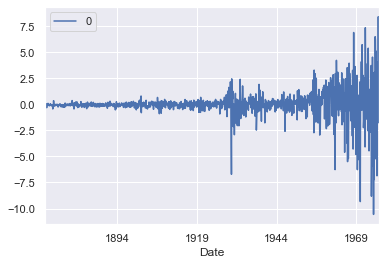

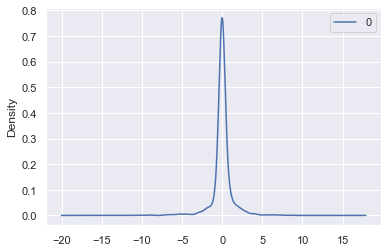

                 0
count  1264.000000
mean      0.000003
std       1.279446
min     -10.566307
25%      -0.223490
50%      -0.018271
75%       0.247902
max       8.413171


In [57]:
from statsmodels.tsa.arima_model import ARIMA
# we'll try  ARIMA(1,1,0)+c = regression of Y_DIFF1 on Y_DIFF1_LAG1 (1st-order AR model
# applied to first difference of Y))
model = ARIMA(y_train, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

We can now examine the  plot for residual errors distribution for training data (which captures the period till 1976-05). According to table the errors seem to be closely centered around 0, it resembles somewhat like normal distribution although seem to have some tails.
Also in the first plot we see huge clusters of volatility reaching highest magnitude lasting for a decade since late '20s and some notable clusteres thereafter closer to end 70's

In [58]:
history = [x for x in y_train]
predictions = list()
for t in range(len(y_test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=101.099480, expected=101.800000
predicted=101.996092, expected=104.200000
predicted=104.808718, expected=103.300000
predicted=103.156310, expected=105.500000
predicted=106.058135, expected=101.900000
predicted=101.161933, expected=101.200000
predicted=101.104214, expected=104.700000
predicted=105.532530, expected=103.800000
predicted=103.665252, expected=101.000000
predicted=100.446626, expected=100.600000
predicted=100.571538, expected=99.050000
predicted=98.768628, expected=98.760000
predicted=98.754244, expected=99.290000
predicted=99.464004, expected=100.200000
predicted=100.457800, expected=97.750000
predicted=97.273007, expected=96.230000
predicted=95.952881, expected=93.740000
predicted=93.244717, expected=94.280000
predicted=94.453246, expected=93.820000
predicted=93.773448, expected=90.250000
predicted=89.515844, expected=88.980000
predicted=88.750440, expected=88.820000
predicted=88.835738, expected=92.710000
predicted=93.621879, expected=97.410000
predicted=98.5328

predicted=453.090205, expected=443.080000
predicted=441.042195, expected=445.250000
predicted=446.138553, expected=448.060000
predicted=449.151691, expected=447.290000
predicted=447.254200, expected=454.130000
predicted=456.488143, expected=459.240000
predicted=461.062556, expected=463.900000
predicted=465.586533, expected=462.890000
predicted=462.784323, expected=465.950000
predicted=467.128525, expected=472.990000
predicted=475.432833, expected=471.580000
predicted=471.353308, expected=463.810000
predicted=461.572582, expected=447.230000
predicted=442.081404, expected=450.900000
predicted=452.257222, expected=454.830000
predicted=456.272360, expected=451.400000
predicted=450.534198, expected=464.240000
predicted=468.429457, expected=466.960000
predicted=468.014519, expected=463.810000
predicted=463.054359, expected=461.010000
predicted=460.359292, expected=455.190000
predicted=453.599336, expected=465.250000
predicted=468.532114, expected=481.920000
predicted=487.356130, expected=493

In [59]:
mse = mean_squared_error(y_test, predictions)
#typically in fin applications rmse is used
rmse = np.sqrt(mse)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 35.993




Let's run the another model with 2nd order of differencing 

C:\Users\DELL-PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DELL-PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D2.P   No. Observations:                 1263
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -2316.862
Method:                       css-mle   S.D. of innovations              1.515
Date:                Mon, 08 Jun 2020   AIC                           4639.723
Time:                        14:10:45   BIC                           4655.147
Sample:                    03-01-1871   HQIC                          4645.519
                         - 05-01-1976                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.031     -0.009      0.993      -0.061       0.061
ar.L1.D2.P    -0.3727      0.026    -14.275      0.000      -0.424      -0.321
                                    Roots           

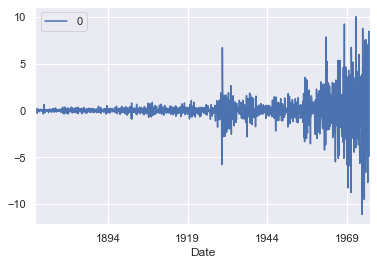

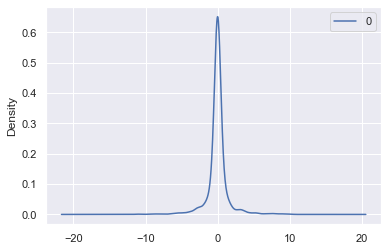

                 0
count  1263.000000
mean      0.000015
std       1.515598
min     -11.105229
25%      -0.264160
50%       0.000398
75%       0.266578
max      10.006025


In [60]:
# this one uses 2nd order of differencing:
# ARIMA(2,1,0)+c = regression of Y_DIFF1 on Y_DIFF1_LAG1 & Y_DIFF1_LAG2
# (2nd-order AR model applied to 1st difference of Y)
model = ARIMA(y_train, order=(1,2,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [61]:
history = [x for x in y_train]
predictions1 = list()
for t in range(len(y_test)):
    model1 = ARIMA(history, order=(1,2,0))
    model_fit1 = model1.fit(disp=0)
    output = model_fit1.forecast()
    yhat1 = output[0]
    predictions1.append(yhat1)
    obs1 = y_test[t]
    history.append(obs1)
    print('predicted=%f, expected=%f' % (yhat1, obs1))

predicted=101.058585, expected=101.800000
predicted=101.915307, expected=104.200000
predicted=105.932207, expected=103.300000
predicted=103.632489, expected=105.500000
predicted=106.537880, expected=101.900000
predicted=100.499160, expected=101.200000
predicted=99.394140, expected=104.700000
predicted=106.622173, expected=103.800000
predicted=104.570887, expected=101.000000
predicted=98.910270, expected=100.600000
predicted=99.296166, expected=99.050000
predicted=97.931282, expected=98.760000
predicted=97.994805, expected=99.290000
predicted=99.511878, expected=100.200000
predicted=100.967947, expected=97.750000
predicted=96.562475, expected=96.230000
predicted=94.358394, expected=93.740000
predicted=91.612342, expected=94.280000
predicted=93.677802, expected=93.820000
predicted=93.736432, expected=90.250000
predicted=87.845487, expected=88.980000
predicted=86.841428, expected=88.820000
predicted=88.242700, expected=92.710000
predicted=95.088117, expected=97.410000
predicted=101.813889

predicted=444.759826, expected=448.060000
predicted=450.689143, expected=447.290000
predicted=447.544725, expected=454.130000
predicted=458.787616, expected=459.240000
predicted=464.851604, expected=463.900000
predicted=468.693307, expected=462.890000
predicted=463.507438, expected=465.950000
predicted=467.841080, expected=472.990000
predicted=478.894384, expected=471.580000
predicted=472.604223, expected=463.810000
predicted=457.844125, expected=447.230000
predicted=433.116284, expected=450.900000
predicted=448.723354, expected=454.830000
predicted=458.689710, expected=451.400000
predicted=450.052072, expected=464.240000
predicted=472.404235, expected=466.960000
predicted=472.637978, expected=463.810000
predicted=462.348047, expected=461.010000
predicted=458.106816, expected=455.190000
predicted=450.233875, expected=465.250000
predicted=470.717116, expected=481.920000
predicted=496.741032, expected=493.150000
predicted=505.928781, expected=507.910000
predicted=521.682211, expected=523

predicted=1060.873244, expected=1044.550000
predicted=1093.367538, expected=1067.660000
predicted=1094.952644, expected=1088.070000
predicted=1109.456235, expected=1110.380000
predicted=1132.032739, expected=1123.580000
predicted=1140.029031, expected=1089.160000
predicted=1071.600553, expected=1152.050000
predicted=1179.824958, expected=1197.320000
predicted=1248.942482, expected=1125.060000
predicted=1094.423940, expected=1083.360000
predicted=1030.854992, expected=1079.800000
predicted=1062.890503, expected=1087.280000
predicted=1090.919927, expected=1122.080000
predicted=1147.406221, expected=1171.580000
predicted=1216.023445, expected=1198.890000
predicted=1233.924171, expected=1241.530000
predicted=1278.878680, expected=1282.620000
predicted=1324.281213, expected=1321.120000
predicted=1360.550283, expected=1304.490000
predicted=1306.978860, expected=1331.510000
predicted=1343.304916, expected=1338.310000
predicted=1352.185427, expected=1287.290000
predicted=1256.320032, expected=

In [62]:
mse = mean_squared_error(y_test, predictions1)
#typically in fin applications rmse is used
rmse = np.sqrt(mse)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 43.085


So, indeed, increasing the differencing order from 1 to 2 worsens the model (RMSE: 35.993 for 1st order differencing vs RMSE: 43.085). Hence we keep the first model as a good one and plot the results of predicitond for it

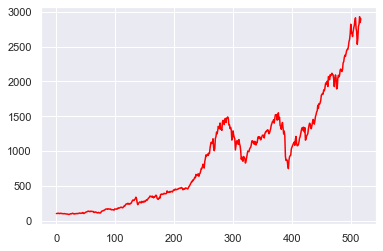

In [63]:

# plot
df_pred = DataFrame(predictions)
pyplot.plot(df_pred, color='red')
pyplot.show()

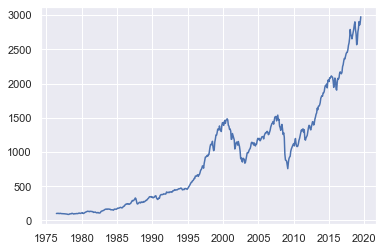

In [64]:
pyplot.plot(y_test)
pyplot.show()

optimal ARIMA model could be also found using Out-of-Time Cross validation, [12]

### Limitations
This model does not account for inflation - consistently defined and longterm running series on U.S. inflation since the 1920’s does not exist and inflation expectations could be modelled as the average of the predicted CPI inflation rate over the next 10 years generated from an AR model at any month in time [10].
Model's behaviour in case of negative interest rates remains a topic for investigation

#### References are provided at the end of 2nd notebook